In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import cPickle

In [21]:
labeled_images = pd.read_csv('./train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]
#xtrain, xval,ytrain, yval = train_test_split(images, labels, train_size=0.8, random_state=0)
#print xtrain.shape, xval.shape, ytrain.shape, yval.shape
xtrain=images.as_matrix()
ytrain=labels.as_matrix()
print xtrain.shape, ytrain.shape

labeled_images = pd.read_csv('./test.csv')
xtest=labeled_images.as_matrix()
print xtest.shape

(42000, 784) (42000, 1)
(28000, 784)


In [22]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

(784,)
number of training examples = 42000
number of test examples = 28000
X_train shape: (42000, 784)
Y_train shape: (42000, 10)
X_test shape: (28000, 784)


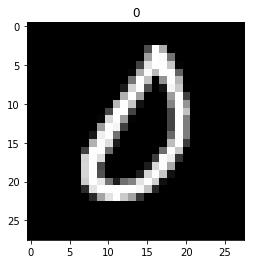

In [23]:
i=111
img=images.iloc[i].as_matrix()
print img.shape
img=img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(labels.iloc[i,0])


xtrain = xtrain/255.
xtest = xtest/255.
ytrain = convert_to_one_hot(ytrain, 10).T

print ("number of training examples = " + str(xtrain.shape[0]))
print ("number of test examples = " + str(xtest.shape[0]))
print ("X_train shape: " + str(xtrain.shape))
print ("Y_train shape: " + str(ytrain.shape))
print ("X_test shape: " + str(xtest.shape))


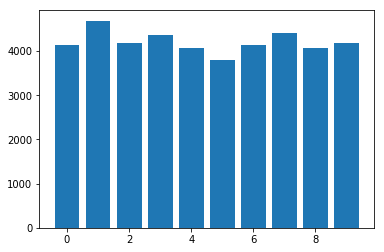

In [24]:
a = labels.apply(pd.value_counts).reset_index()
plt.bar(a['index'], a['label'])
plt.show()

In [25]:
def create_placeholders(nx, ny):
    X = tf.placeholder(shape=[None, nx], dtype=tf.float32)
    Y = tf.placeholder(shape=[None, ny], dtype=tf.float32)
    return X, Y

In [50]:
def initialize_parameters(nx, ny):
    W1 = tf.Variable(tf.truncated_normal([nx, 50], mean=0, stddev=1 / np.sqrt(nx)), name='W1')
    b1 = tf.Variable(tf.truncated_normal([50],mean=0, stddev=1 / np.sqrt(nx)), name='b1')
    
    W2 = tf.Variable(tf.random_normal([50, 50],mean=0,stddev=1/np.sqrt(nx)),name='W2')
    b2 = tf.Variable(tf.random_normal([50],mean=0,stddev=1/np.sqrt(nx)),name='b2')

    W3 = tf.Variable(tf.random_normal([50, ny], mean=0, stddev=1/np.sqrt(nx)), name='W3')
    b3 = tf.Variable(tf.random_normal([ny], mean=0, stddev=1/np.sqrt(nx)), name='b3')

    #W1 = tf.get_variable("W1", [100,nx], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    #b1 = tf.get_variable("b1", [100,1], initializer=tf.zeros_initializer())
    
    #W2 = tf.get_variable("W2", [ny,100], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    #b2 = tf.get_variable("b2", [ny,1], initializer=tf.zeros_initializer())
    
    parameters = {"W1": W1, "b1" : b1, "W3" : W3, 
                  "W2": W2, "b2" : b2, "b3" : b3 }
    
    return parameters

In [43]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #Z1 = tf.add(tf.matmul(W1, X), b1)
    #A1 = tf.nn.relu(Z1)
    #Z2 = tf.add(tf.matmul(W2, A1), b2)
    #return Z2
    
    A1 = tf.nn.tanh((tf.matmul(X, W1)+b1), name='A1')
    A2 = tf.nn.sigmoid((tf.matmul(A1,W2)+b2),name='A2')
    A3 = tf.nn.softmax((tf.matmul(A2, W3) + b3), name='A3')
    
    
    return A3

In [44]:
def compute_cost(A, Y):
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z2, labels = Y))
    cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(A),reduction_indices=[1]))
    return cost

In [45]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0): 
    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [51]:
def model(X_train, Y_train, X_test, learning_rate = 0.0001,
          num_epochs = 180, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph() 
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, nx) = X_train.shape             
    ny = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(nx, ny)
    parameters = initialize_parameters(nx, ny)
    Z2 = forward_propagation(X, parameters)
    cost = compute_cost(Z2, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z2, 1), tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        #test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        #print("Test Accuracy:", test_accuracy)
        y_pred = sess.run(tf.argmax(Z2, 1), feed_dict={X: xtest})
        cPickle.dump(y_pred,open('ytest.p','wb'))
        return train_accuracy, parameters

Cost after epoch 0: 1.926840
Cost after epoch 5: 0.386843
Cost after epoch 10: 0.237513
Cost after epoch 15: 0.176747
Cost after epoch 20: 0.139681
Cost after epoch 25: 0.113941
Cost after epoch 30: 0.095047
Cost after epoch 35: 0.080285
Cost after epoch 40: 0.067884
Cost after epoch 45: 0.057947
Cost after epoch 50: 0.049338
Cost after epoch 55: 0.042004
Cost after epoch 60: 0.035362
Cost after epoch 65: 0.029801
Cost after epoch 70: 0.025112
Cost after epoch 75: 0.020876
Cost after epoch 80: 0.017066
Cost after epoch 85: 0.013783
Cost after epoch 90: 0.011162
Cost after epoch 95: 0.008742
Cost after epoch 100: 0.006865
Cost after epoch 105: 0.005344
Cost after epoch 110: 0.004153
Cost after epoch 115: 0.003179
Cost after epoch 120: 0.002427
Cost after epoch 125: 0.001769
Cost after epoch 130: 0.001282
Cost after epoch 135: 0.000920
Cost after epoch 140: 0.000657
Cost after epoch 145: 0.000464
Cost after epoch 150: 0.000315
Cost after epoch 155: 0.000216
Cost after epoch 160: 0.000148

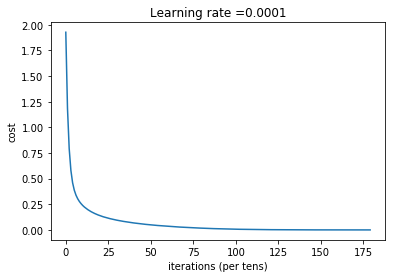

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 1.0)


In [52]:
_, parameters = model(xtrain, ytrain, xtest)